# Capstone: Supervised Learning (Extended Supervised Learning Notebook)

House Prices: Advanced Regression Techniques - The Kaggle Competition

The Ames Housing dataset was compiled by Dean De Cock for use in data science education. With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Metric: Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

## Notebook Flow:
    * Importing Data
    * Identifying and Handling Missing Data
    * Data Exploration 
        * Identifying Variable Types
        * Skew Detection & Resolution
        * Bivariate Analysis
            * Lot Variables 
            * Porch Variables 
            * Basement & Utility Variables 
            * Bed Variables 
            * Time Series Variables
    * Modeling
        * GradientBoostingRegressor
        * eXtremeGradientBoosting
    * Predictions
    * Results  

## Importing Data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import boxcox1p, inv_boxcox1p
from scipy.stats import stats
from scipy.stats import skew
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn import preprocessing
import math
%matplotlib inline
PATH = r'C:\Users\latee\Documents\GitHub\Supervised Capstone\house-prices-advanced-regression-techniques\train.csv'
house_t = pd.read_csv(PATH)

## Identifying and Handling Missing Data

In [2]:
# making all column names lowercase
house_t.columns = map(str.lower, house_t.columns)
non_numeric_columns = house_t.select_dtypes(['object']).columns
numeric_columns = house_t.select_dtypes(['int64', 'float64']).columns
total_missing = house_t.isnull().sum().sort_values(ascending=False)
percent_missing = (house_t.isnull().sum()/house_t.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
print('Missing Data & Percentage')
missing_data.head(19)

Missing Data & Percentage


,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


###   Special Notes about Data from Kaggle

In the text file that came with the data, it tells us that

* PoolQC : NA means No Pool
* Fence : NA means No Fence
* MiscFeature : NA means "no misc feature"
* Alley : NA means "no alley access"
* FireplaceQu : NA means "no fireplace"

Here are some other decisions I made when imputing data based on available information 

* NA values relating to a garage is because they do not have one
* NA values relating to a basement is because they don't have one
* NA values relating to a masonry veneer is because this isn't one
* Electrical system can be interpolated with the most common value in that neighborhood
    - Refers to: Electrical System in the house
* LotFrontage can be interpolated with the most common value in that neighborhood
    * Linear feet of street-connected to property

In [3]:
# filling in missing data according to notes 
for col in ('poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ', 'garagecond',
            'garagetype', 'garageyrblt', 'garagefinish', 'garagequal', 'bsmtexposure',
            'bsmtfintype2', 'bsmtfintype1', 'bsmtcond', 'bsmtqual', 'masvnrarea', 'masvnrtype'):
    house_t[col] = house_t[col].fillna('None')
# get a list of neightborhoods
neighborhoods = house_t['neighborhood'].unique()
# fill na values with average based on neighborhood
for col in ['lotfrontage']:
    for neighborhood in neighborhoods:
        house_t.loc[house_t["neighborhood"] == neighborhood, col] = house_t.loc[house_t["neighborhood"] == neighborhood, col].fillna(
            house_t[house_t["neighborhood"] == neighborhood][col].mean())
# fill na values with average based on the neighborhood count for that value
for col in ['electrical']:
    for neighborhood in neighborhoods:
        house_t.loc[house_t["neighborhood"] == neighborhood, col] = house_t.loc[house_t["neighborhood"] == neighborhood, col].fillna(
            house_t[house_t["neighborhood"] == neighborhood][col].value_counts().index[0])

## Data Exploration

### Identifying Feature Types

First, let's visualize the numerical features. 

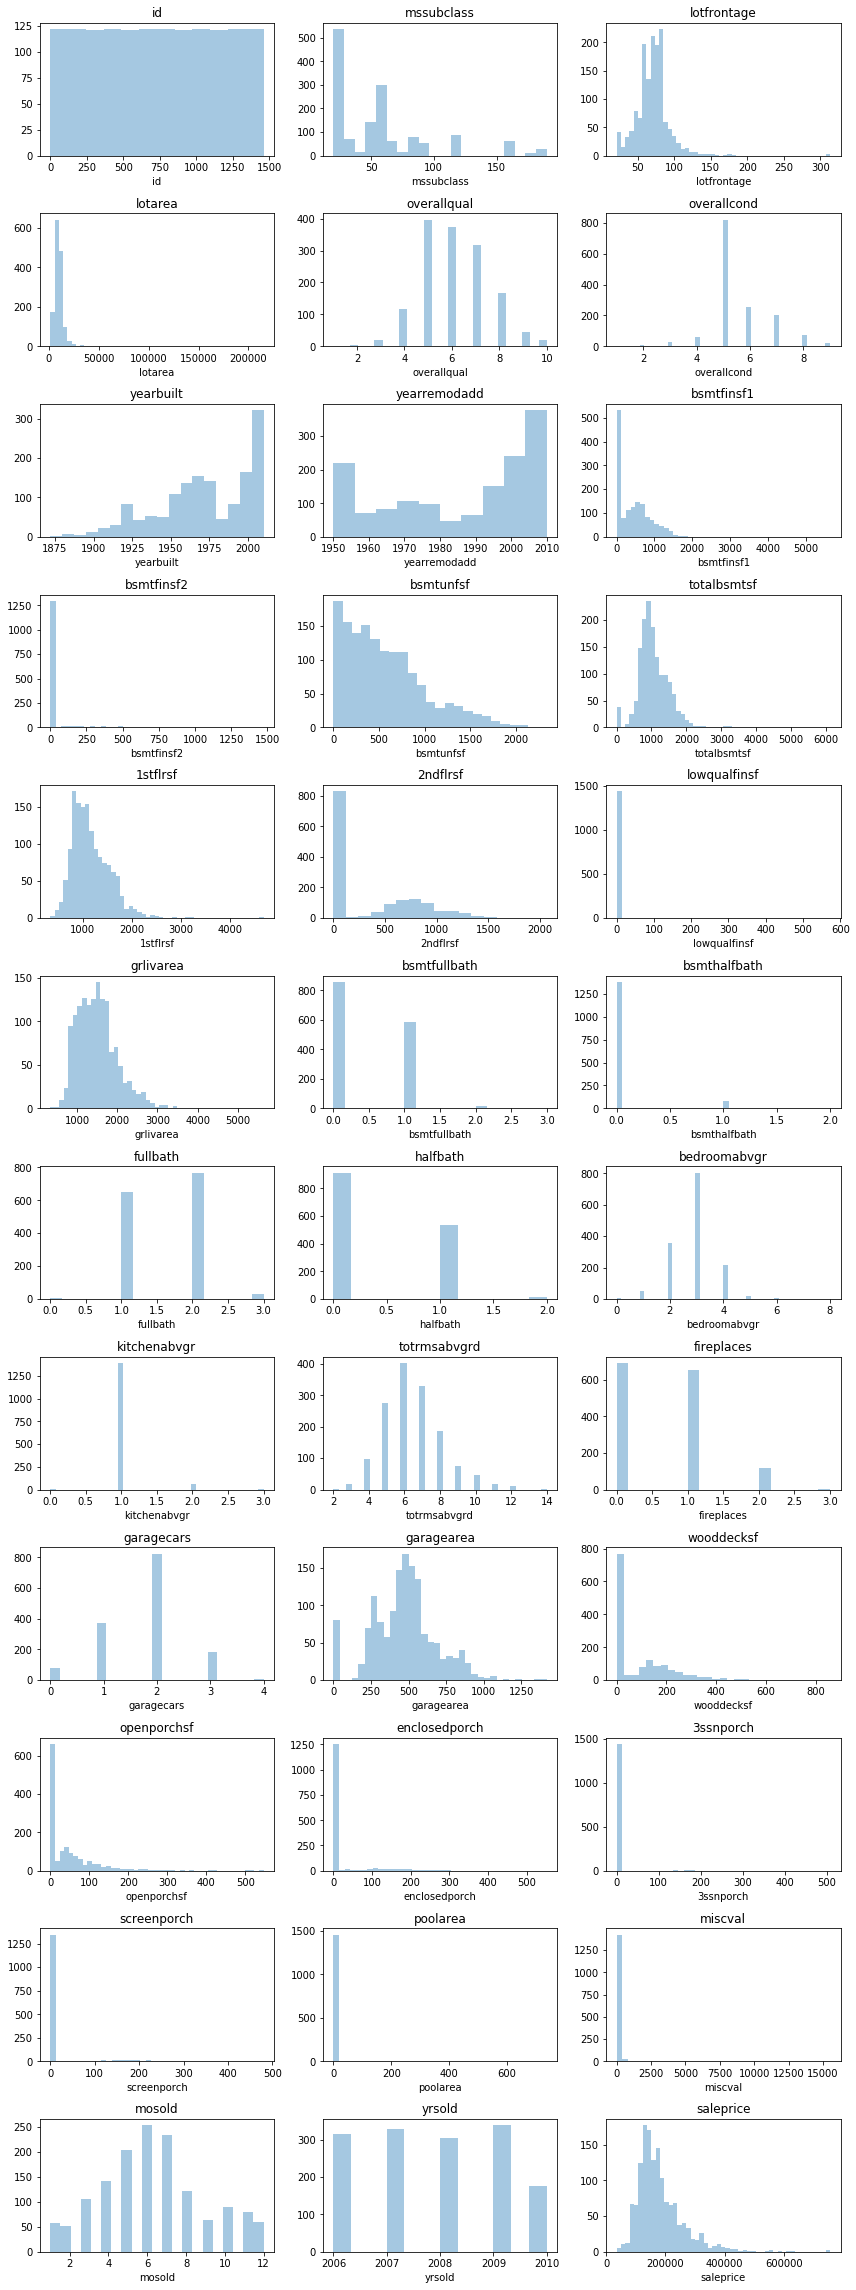

In [4]:
# resetting numeric and non-numeric columns
non_numeric_columns = house_t.select_dtypes(['object']).columns
numeric_columns = house_t.select_dtypes(['int64', 'float64']).columns
FILL_LIST = []
for cols in house_t[:]:
    if cols in numeric_columns:
        FILL_LIST.append(cols)
plt.figure(figsize=(12, 95))
plt.subplots_adjust(hspace=1, wspace=1)
for i, col in enumerate(FILL_LIST):
    try:
        plt.subplot(len(FILL_LIST), 3, i+1)
        sns.distplot(house_t[col], kde=False)
        plt.title(col)
    except TypeError:
        pass
plt.tight_layout()

Looks like there are some categorical data in here mixed-in as numerical. Also, I do not want to treat discrete variables as continuous. The following must be considered when looking at certain features. 

id will be saved for later, but otherwise not needed. 

mssubclass - the type of dwelling involved in the sale, but is recorded as integers between 20 and 190 but the significance of those digits and their distances between each other are not informative 

yearbuilt - time

YearRemodAdd: Remodel date - time

MoSold: Month Sold (MM) - time

YrSold: Year Sold (YYYY) - time

garageyrblt: Year garage was built - time

overallcond: Rates the overall condition of the house - scale 1 - 10

overallqual - Rates the overall condition of the house - scale 1 - 10

bsmtfullbath: Basement full bathrooms - a count

bsmthalfbath: Basement half bathrooms - a count

fullbath: Full bathrooms above grade - a count

halfbath: Half baths above grade - a count

bedroomabvgr: Bedrooms above grade (does NOT include basement bedrooms) - a count

kitchenabvgr: Kitchens above grade - a count

totrmsabvgrd: Total rooms above grade (does not include bathrooms) - a count

fireplaces: Number of fireplaces - a count

garagecars: Size of garage in car capacity - a count

* Special Note: grade - is the basement level

In [5]:
# saving the id column for later
house_t_id = house_t['id']
# dropping id column
house_t = house_t.drop(['id'], axis=1)
for col in ('yrsold', 'mosold', 'overallcond', 'yearremodadd', 'yearbuilt', 'mssubclass', 'garagecars',
            'garageyrblt', 'fireplaces', 'totrmsabvgrd', 'kitchenabvgr', 'bedroomabvgr', 'halfbath', 'fullbath',
            'bsmthalfbath', 'bsmtfullbath', 'overallqual'):
    house_t[col] = house_t[col].astype(str)

### Skew Detection & Resolution

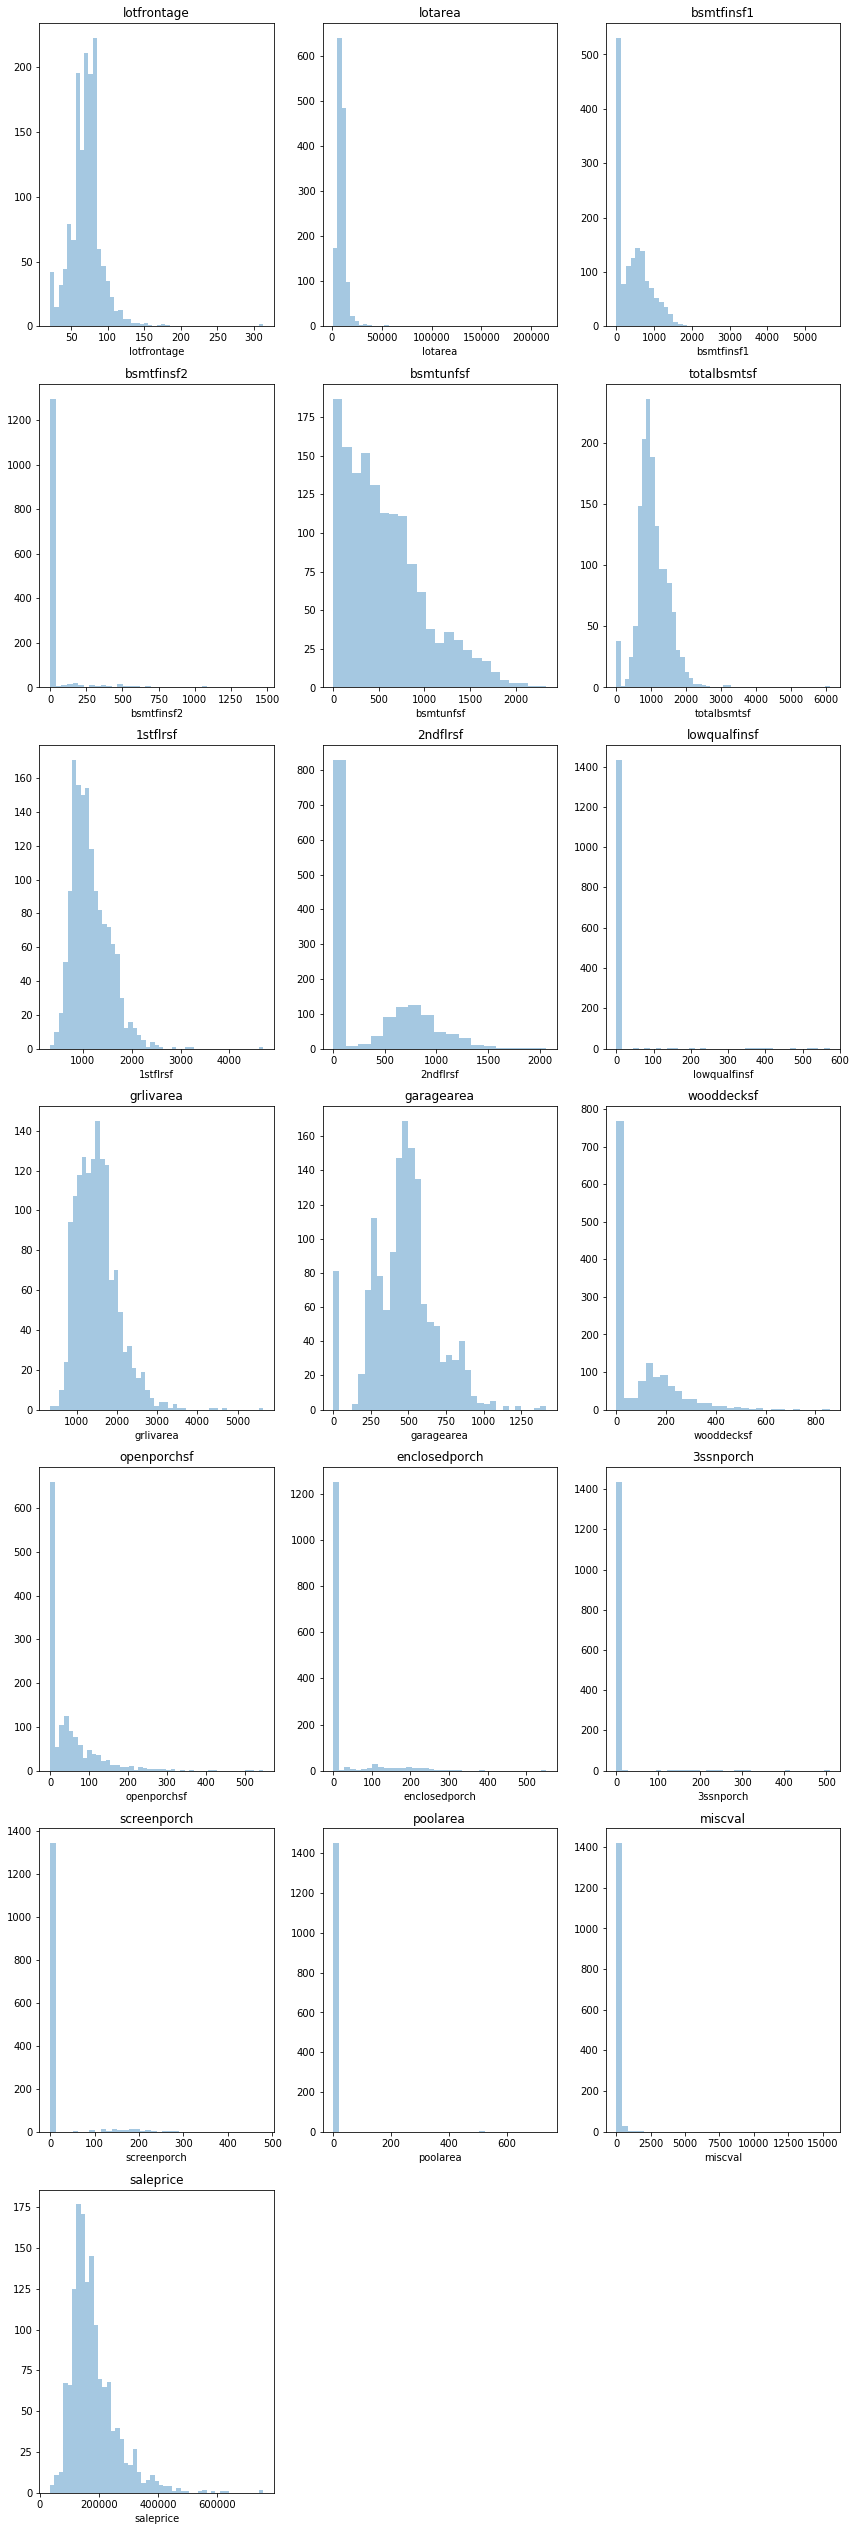

In [6]:
# resetting numeric and non-numeric columns
non_numeric_columns = house_t.select_dtypes(['object']).columns
numeric_columns = house_t.select_dtypes(['int64', 'float64']).columns
FILL_LIST = []
for cols in house_t[:]:
    if cols in numeric_columns:
        FILL_LIST.append(cols)
plt.figure(figsize=(12, 95))
plt.subplots_adjust(hspace=1, wspace=1)
for i, col in enumerate(FILL_LIST):
    try:
        plt.subplot(len(FILL_LIST), 3, i+1)
        sns.distplot(house_t[col], kde=False)
        plt.title(col)
    except TypeError:
        pass
plt.tight_layout()

Revisiting our distribution graphic

We can see there is a lot of long right tails (features skewed to the right), this is what I expect from variables that are counting or quantifying the physical properties of a house. 

The fact that all of our numerical features represent positive data means that we could use a log or BoxCox transformation to address their skew. I'll apply a boxcox transformation to some of the features here.

Before applying any transformations, I will find out which features are most skewed and transform the most skewed features. First

In [7]:
jb_stats = jarque_bera(house_t['saleprice'])
norm_stats = normaltest(house_t['saleprice'])
print("Saleprice Normality Test Results")
print("\n\nJarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1} \n".format(norm_stats[0], norm_stats[1]))

Saleprice Normality Test Results


Jarque-Bera test statistics is 3438.8721241220583 and p value is 0.0
Normality test statistics is 610.8359109472653 and p value is 2.283848353787728e-133 



Notes on tests 

In statistics, the Jarque–Bera test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution. The test is named after Carlos Jarque and Anil K. Bera. The test statistic is always nonnegative. If it is far from zero, it signals the data do not have a normal distribution.

In statistics, normality tests are used to determine if a data set is well-modeled by a normal distribution and to compute how likely it is for a random variable underlying the data set to be normally distributed.

With this in mind, we can conclude that our target saleprice is not normally distributed. 

In [8]:
# Check the skew of all numerical features
skewed_feats = house_t[numeric_columns].apply(lambda x: skew(x)).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)


Skew in numerical features: 



,Skew
miscval,24.451640
poolarea,14.813135
lotarea,12.195142
3ssnporch,10.293752
lowqualfinsf,9.002080
bsmtfinsf2,4.250888
screenporch,4.117977
enclosedporch,3.086696
openporchsf,2.361912
lotfrontage,2.159204


In [9]:
# transform skewed numerical variables (those of which absolute value is greater than .75)
skewness = skewness[abs(skewness.Skew)>0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    house_t[feat] = boxcox1p(house_t[feat], lam)

There are 18 skewed numerical features to Box Cox transform


In [10]:
print('Below are the variables to be transformed')
skewness.index

Below are the variables to be transformed


Index(['miscval', 'poolarea', 'lotarea', '3ssnporch', 'lowqualfinsf',
       'bsmtfinsf2', 'screenporch', 'enclosedporch', 'openporchsf',
       'lotfrontage', 'saleprice', 'bsmtfinsf1', 'wooddecksf', 'totalbsmtsf',
       '1stflrsf', 'grlivarea', 'bsmtunfsf', '2ndflrsf'],
      dtype='object')

In [11]:
# Check the skew reduction of all numerical features
skewed_feats = house_t[numeric_columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nNew Skew in numerical features:")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)


New Skew in numerical features:


,Skew
poolarea,14.363418
3ssnporch,7.827826
lowqualfinsf,7.593301
miscval,5.505530
screenporch,3.184431
bsmtfinsf2,2.619350
enclosedporch,2.160966
lotarea,0.751948
saleprice,0.368049
2ndflrsf,0.310478


In [12]:
jb_stats = jarque_bera(house_t['saleprice'])
norm_stats = normaltest(house_t['saleprice'])
print("Saleprice Normality Test Results")
print("\n\nJarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1} \n".format(norm_stats[0], norm_stats[1]))

Saleprice Normality Test Results


Jarque-Bera test statistics is 78.02299500633683 and p value is 0.0
Normality test statistics is 55.52062699987806 and p value is 8.787170051798085e-13 



Compared to before the transformation, we can see that our target is more normalized as the result from the Jarque-Bera test gave us a test statistic closer to 0 and the normality test gave us a p-value closer to one. 

Let's take a look at the densities of the transformed variables. 

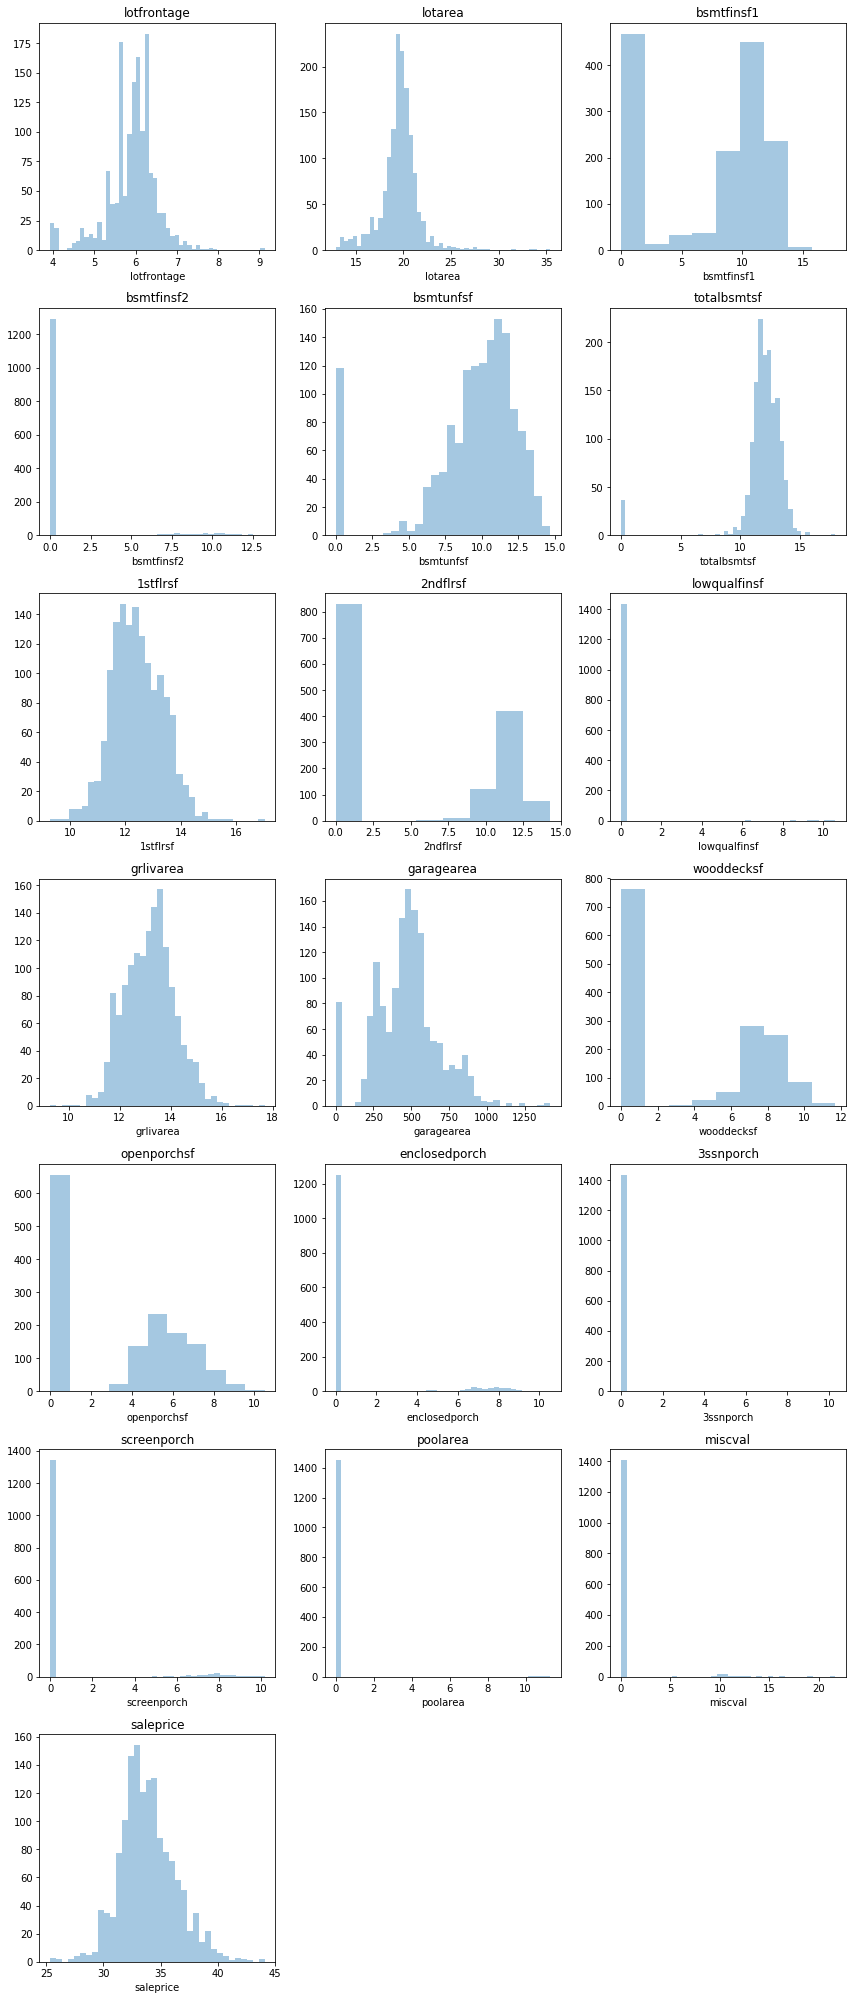

In [13]:
plt.figure(figsize=(12, 75))
plt.subplots_adjust(hspace=1, wspace=1)
for i, col in enumerate(FILL_LIST):
    try:
        plt.subplot(len(FILL_LIST), 3, i+1)
        sns.distplot(house_t[col], kde=False)
        plt.title(col)
    except TypeError:
        pass
plt.tight_layout()

So the skew is reduced and the transformed features appear to be more normal


### Bivariate Analysis


This section includes - Variable/Target correlations, Demintionality Reduction + Outlier Dectection, and Outlier Resolution

From this analysis 2 datasets will be produced, one with all the original variables listed and new variables created, the second dataset will have a reduced set of features that I determined are the most important when attempting to predict saleprice. 

I have broken the variables into five distinct groups and evaluated the groups of variables individually and with each other. The five groups are Lot Variables, Porch Variables, Basement Variables, Bedroom Variables, and Time Based Variables. 

We'll be interested in variables that are + or - .3 correlated with our target using Pearson's Correlation Coefficient. We are mostly interested in identifying variables that have some useful explanatory power relating to our target. 

Outlier detection and resolution
   * For the most part outliers will be somewhat ignored, the plan is to make the models robust to outliers, but eliminate obviously uninformative observations. 

In [14]:
# re-attching the id back on the the main dataframe so we can easily join together dataframes later
house_t['id'] = house_t_id

#### Lot Variables

In [15]:
# creating lot variable df
lot_df = house_t.loc[:, ['id', 'lotfrontage', 'lotarea', 'lotshape', 'street', 'alley', 'landcontour', 'lotconfig',
                         'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'exterior1st',
                         'exterior2nd', 'exterqual', 'extercond', 'foundation', 'paveddrive', 'saleprice']]

In [16]:
# Function to take categorical variables and turn them into numerical variables 
def cat_converter(df):
    # getting columns to convert
    non_numeric_columns = df.select_dtypes(['object']).columns
    for cols in df:
        if cols in non_numeric_columns:
            # Create a label (category) encoder object
            le = preprocessing.LabelEncoder()
            # Create a label (category) encoder object
            le.fit(df[cols].astype(str))
            # Apply the fitted encoder to the pandas column
            df[cols] = le.transform(df[cols].astype(str)) 
    return df
lot_df = cat_converter(lot_df)

In [17]:
# Custom Function Heatmap
def heat_map(df, vmin, vmax):
    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(dpi=155)
    return sns.heatmap(df.corr(), cmap='icefire', mask=mask, vmin=vmin, vmax=vmax)

,saleprice
id,-0.019039
lotfrontage,0.364054
lotarea,0.401093
lotshape,-0.277269
street,0.054826
alley,0.109423
landcontour,0.029583
lotconfig,-0.072191
landslope,0.041683
neighborhood,0.204468


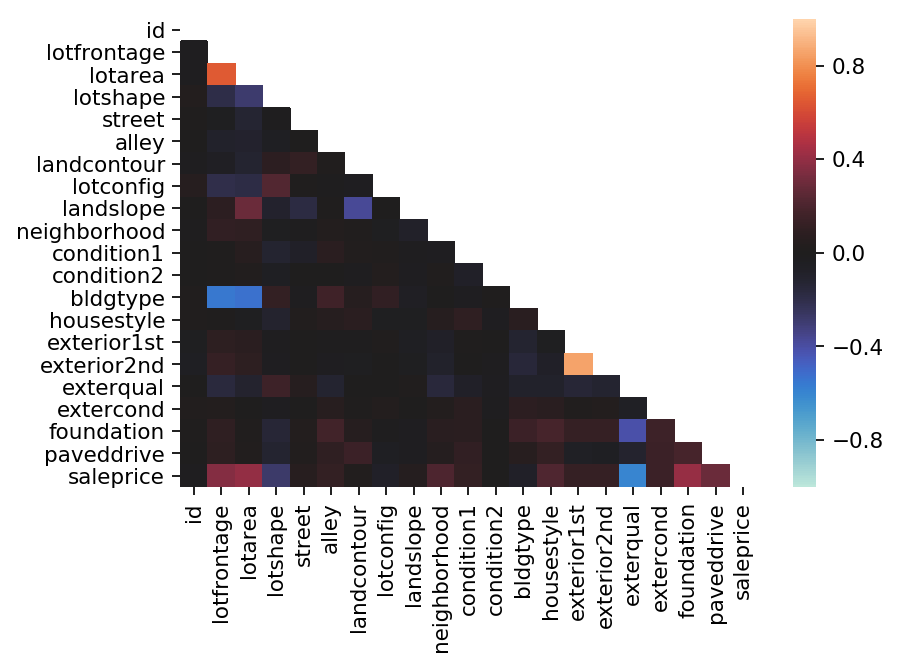

In [18]:
heat_map(lot_df, -1, 1)

lot_corr = lot_df.corr()[-1:]
lot_corr.sort_values(['saleprice'], axis=0).T

It appears that the following variables are correlated with our target:

* Lot frontage
    - Linear feet of street-connected to property
* Lot Area
    - Lot size in square feet
* Foundation
    - Type of Foundation (brick, wood, etc)
* Exterqual
    - Evaluates the quality of the material on the exterior
        - The interesting thing here to note is that a house's exterqual seems to have a negative relationship with our target

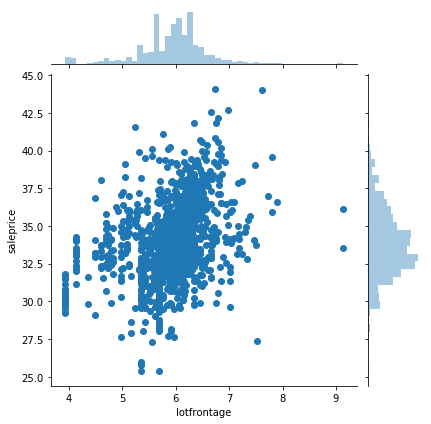

In [19]:
sns.jointplot(x="lotfrontage", y="saleprice", data=lot_df)

In [20]:
lot_df['lotfrontage'].describe()

count    1460.000000
mean        5.911425
std         0.596917
min         3.932510
25%         5.684507
50%         5.971204
75%         6.221214
max         9.125735
Name: lotfrontage, dtype: float64

Those values above nine for 'lotfrontage' (Linear feet of street-connected to property) are clearly outliers given their moderate price and large space between the house and the property. I will clip those two values.

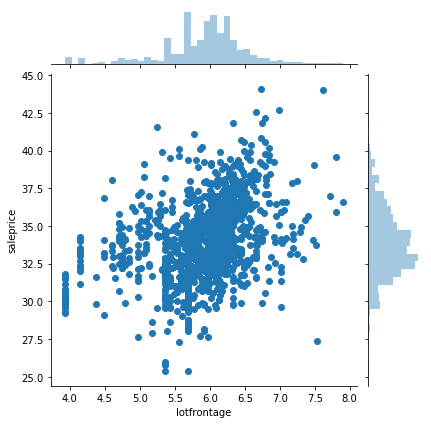

In [21]:
lot_df.drop(lot_df[lot_df['lotfrontage'] >= 9].index, inplace = True, axis=0)
sns.jointplot(x="lotfrontage", y="saleprice", data=lot_df)

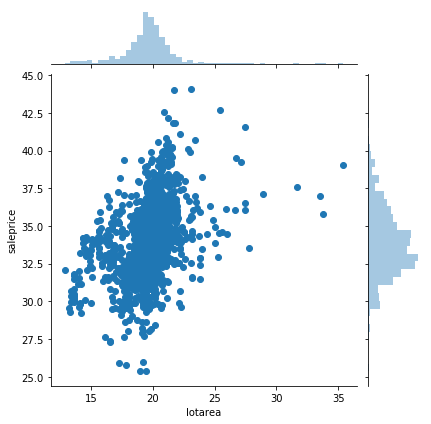

In [22]:
sns.jointplot(x="lotarea", y="saleprice", data=lot_df)

Similar situation here

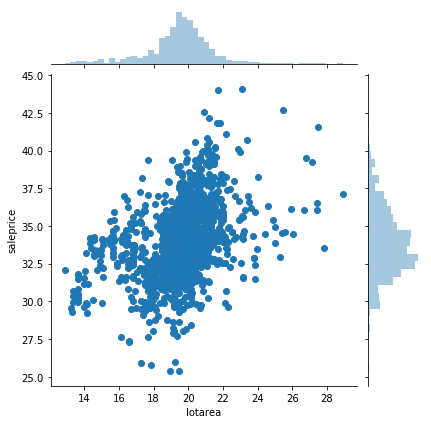

In [23]:
lot_df.drop(lot_df[lot_df['lotarea'] >= 30].index, inplace = True, axis=0)
sns.jointplot(x="lotarea", y="saleprice", data=lot_df)

Okay, that looks better.

Hmm, what if we create a new feature to be the sum of lotfrontage and lotarea? Would we obtain a more informative feature?

Let's try!

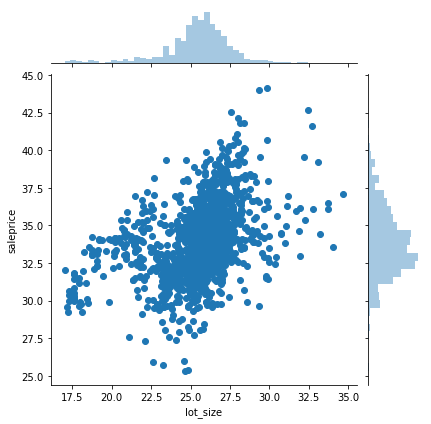

In [24]:
lot_df['lot_size'] = lot_df['lotarea'] + lot_df['lotfrontage']
sns.jointplot(x="lot_size", y="saleprice", data=lot_df)

,saleprice
id,-0.016317
lotfrontage,0.365340
lotarea,0.405053
lotshape,-0.276120
street,0.069134
alley,0.109686
landcontour,0.036410
lotconfig,-0.070726
landslope,0.013096
neighborhood,0.204968


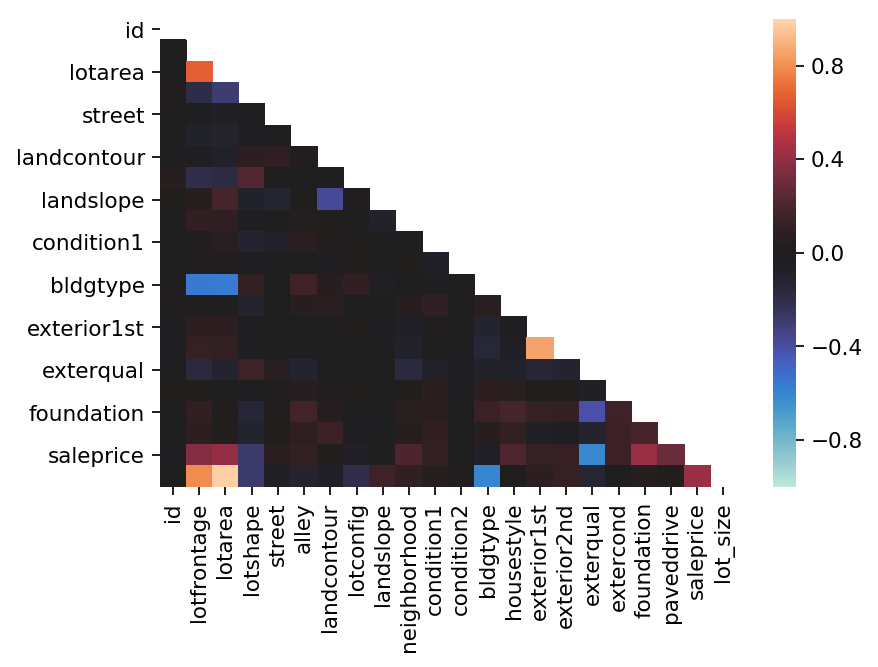

In [25]:
heat_map(lot_df, -1, 1)
lot_corr = lot_df.corr()[-2:-1]
lot_corr.sort_values(['saleprice'], axis=0).T

It looks like our lot size feature is more correlated with our target than any of the 2 original features combined. Nice!

Now let's look into that foundation feature from earlier.

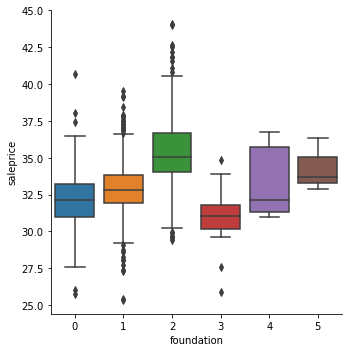

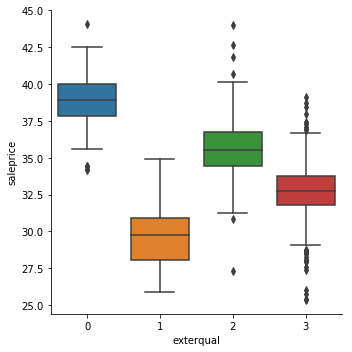

In [26]:
sns.catplot(x="foundation", y="saleprice", kind="box", data=lot_df, whis=1.5)
sns.catplot(x="exterqual", y="saleprice", kind="box", data=lot_df, whis=1.5)

The variance in saleprice when considering the above variables seems a little high. But I'm not too concerned with this right now. 

From that we have:

* foundation
* exterqual
* lot_size
    - due to outliers, we lost 6 observations

In [27]:
# new dataframe saving our features
house_neo = lot_df.loc[:, ['id', 'saleprice', 'foundation', 'exterqual', 'lot_size']]

In [28]:
house_chi = lot_df

#### Porch Variables (zoning/pool/garage/porch)

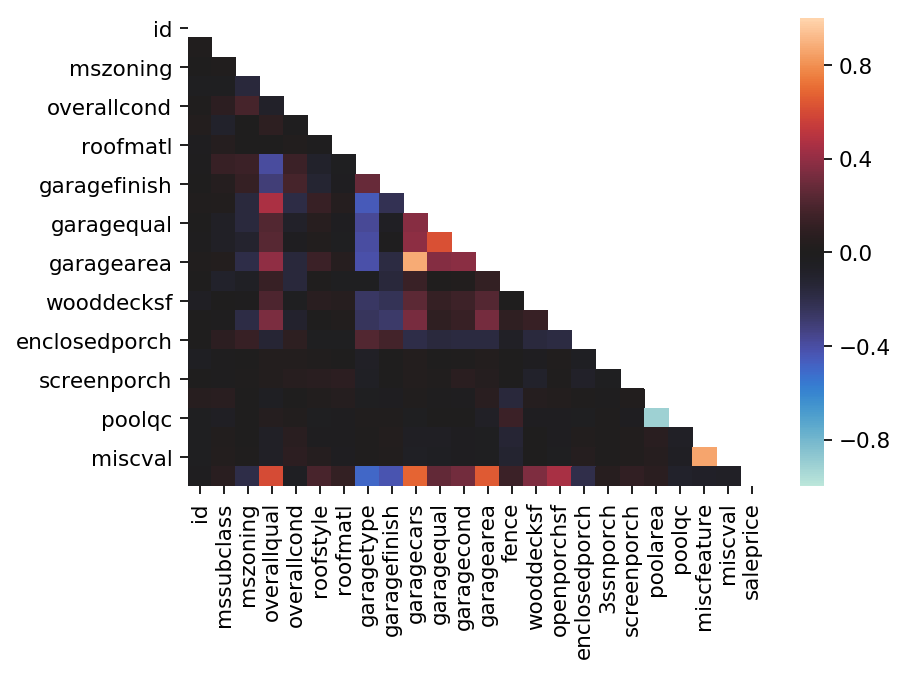

In [29]:
# creating porch variable group df
porch_df = house_t.loc[:, ['id', 'mssubclass', 'mszoning', 'overallqual' , 'overallcond',
                           'roofstyle', 'roofmatl', 'garagetype', 'garagefinish', 'garagecars',
                           'garagequal', 'garagecond', 'garagearea', 'fence', 'wooddecksf',
                           'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea',
                           'poolqc', 'miscfeature', 'miscval', 'saleprice']]
# converting catergorical variables
porch_df = cat_converter(porch_df)
heat_map(porch_df, -1, 1)

These variables meet our +- .3 correlation specification consistent with what we did with the last variable group.

* overallqual 
    - Rates the overall material and finish of the house
* garagetype
    - Garage location at the house
* garagefinish
    - 4 different rating of how finished, from none to completely finished
* garagecond
    - condition rating
* garagearea
    - Size of garage in square feet

In [30]:
# merging dataframes on id
house_chi = pd.merge(house_chi, porch_df, left_on='id', right_on='id', how='outer')

In [31]:
# resetting dataframe
porch_df = porch_df.loc[:, ['id', 'overallqual', 'garagetype', 'garagefinish', 'garagecond', 'garagearea', 'saleprice']]

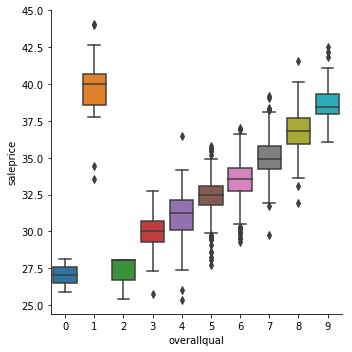

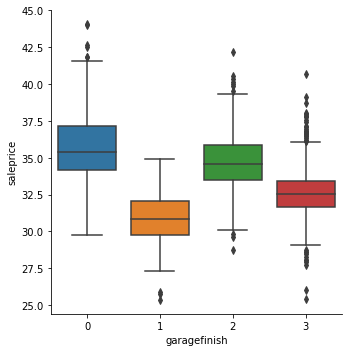

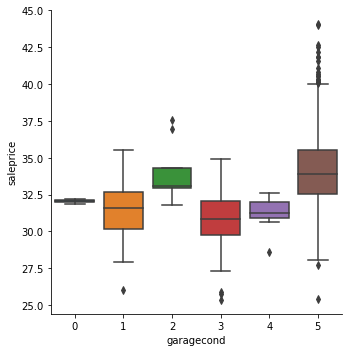

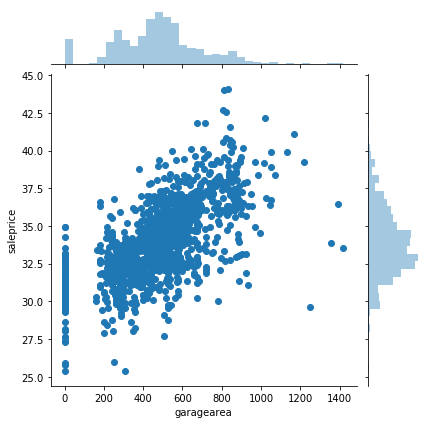

In [32]:
sns.catplot(x="overallqual", y="saleprice", kind='box', data=porch_df, whis=1.5)
sns.catplot(x="garagefinish", y="saleprice", kind='box', data=porch_df, whis=1.5)
sns.catplot(x="garagecond", y="saleprice", kind='box', data=porch_df, whis=1.5)
sns.jointplot(x="garagearea", y="saleprice", data=porch_df)

Those four points with over 1240 seem to be pretty big outliers, so I will clip those values. 

In [33]:
porch_df.drop(porch_df[porch_df['garagearea'] >= 1240].index, inplace = True, axis=0)

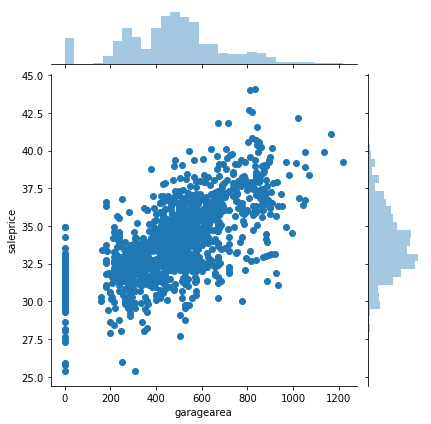

In [34]:
sns.jointplot(x="garagearea", y="saleprice", data=porch_df)

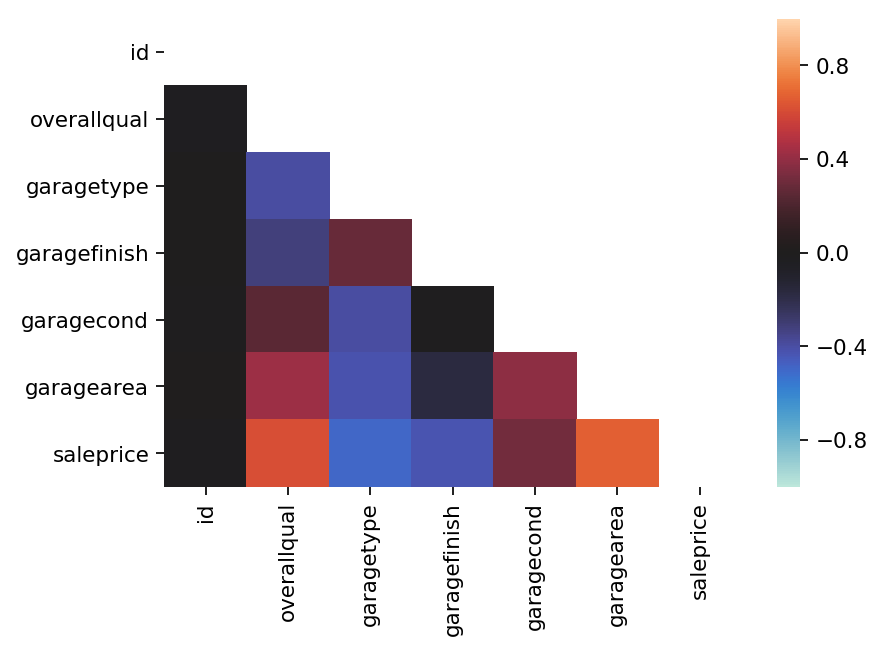

In [35]:
heat_map(porch_df, -1, 1)

In [36]:
# merging dataframes on id
house_neo = pd.merge(house_neo, porch_df, left_on='id', right_on='id', how='outer')

From this set of features we have:

* overallqual
    - Rates the overall material and finish of the house 1 - 10
* garagetype
    - Garage location
* garagefinish
    - Interior finish of the garage from unfinished to finished
* garagecond
    - Garage condition
* garagearea
    - Size of garage in square feet

Onto the next set of features!

#### Basement & Utility Variables

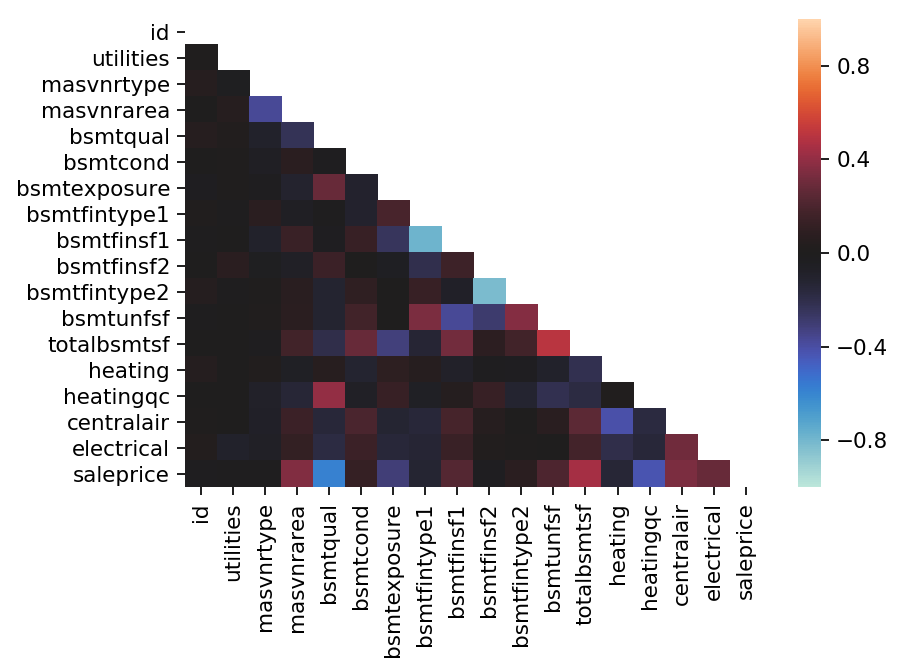

In [37]:
# creating a dataframe of basement & utility variables
base_df = house_t.loc[:, ['id', 'utilities', 'masvnrtype', 'masvnrarea', 'bsmtqual', 'bsmtcond', 'bsmtexposure',
                          'bsmtfintype1', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtfintype2', 'bsmtunfsf',
                          'totalbsmtsf', 'heating', 'heatingqc', 'centralair', 'electrical', 'saleprice']]
base_df = cat_converter(base_df)
heat_map(base_df, -1, 1)

In [38]:
base_df.corr()[-1:].sort_values(by='saleprice', ascending=False).T

,saleprice
id,-0.019039
utilities,-0.013144
masvnrtype,-0.010502
masvnrarea,0.351776
bsmtqual,-0.585001
bsmtcond,0.118006
bsmtexposure,-0.307212
bsmtfintype1,-0.121490
bsmtfinsf1,0.231888
bsmtfinsf2,-0.030851


I am going to look deeper into:

* bsmtqual
    - Evaluates the height of the basement
        - the taller the better from NA or Poor 70< inches to excellent 100inches>
* bsmtexposure
    - Refers to walkout or garden level walls
* totalbsmtsf
    - Total square feet of the basement area
* centralair
    - Central air conditioning (binary)
* masvnrarea
    - Masonry veneer area in square feet
* heatingqc
    - Heating quality and condition

In [39]:
# merging dataframes on id
house_chi = pd.merge(house_chi, base_df, left_on='id', right_on='id', how='outer', copy=False)

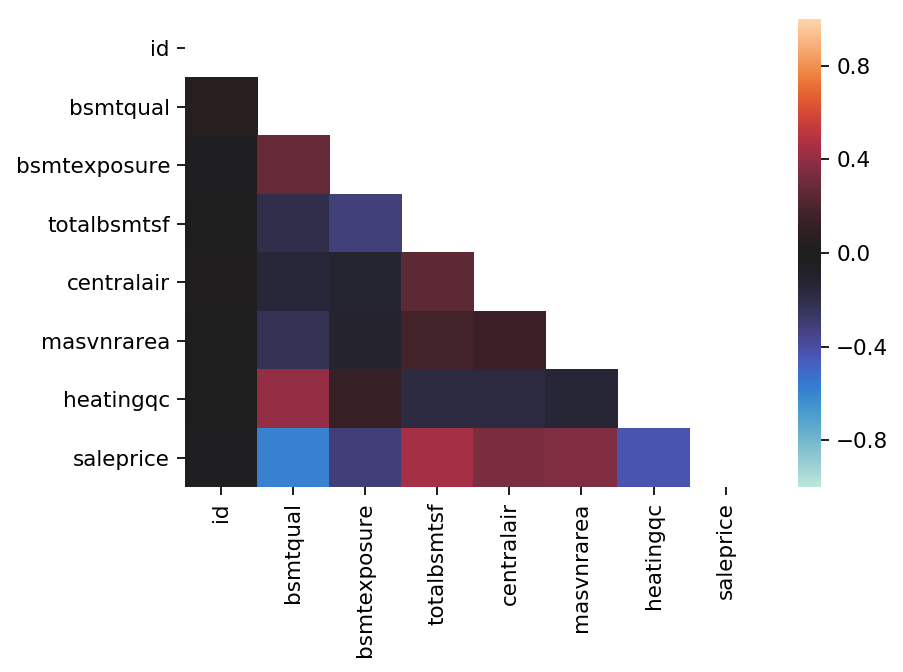

In [40]:
# creating a dataframe of basement & utility variables
base_df = base_df.loc[:, ['id', 'bsmtqual', 'bsmtexposure', 'totalbsmtsf',
                          'centralair', 'masvnrarea', 'heatingqc', 'saleprice']]
heat_map(base_df, -1, 1)

The following variable appears to be highly correlated with out target, but is actually not very informative. 

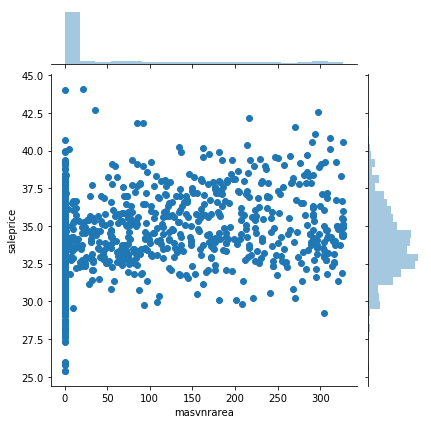

In [41]:
sns.jointplot(x="masvnrarea", y="saleprice", data=base_df)

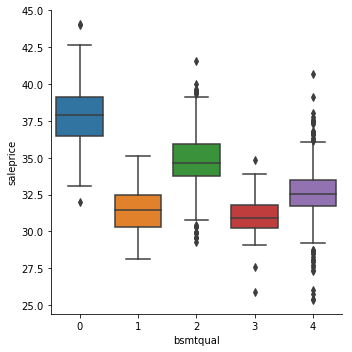

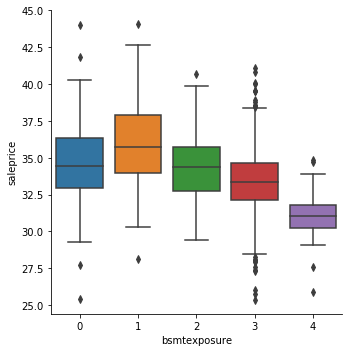

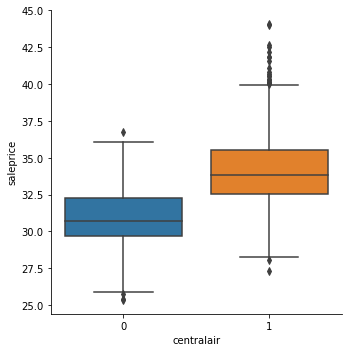

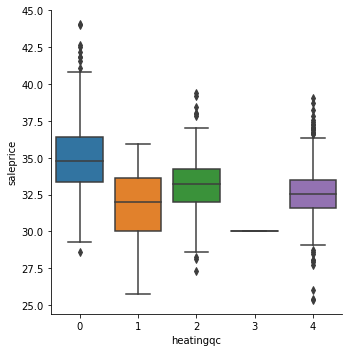

In [42]:
sns.catplot(x="bsmtqual", y="saleprice", kind='box', data=base_df, whis=1.5);
sns.catplot(x="bsmtexposure", y="saleprice", kind='box', data=base_df, whis=1.5);
sns.catplot(x="centralair", y="saleprice", kind='box', data=base_df, whis=1.5);
sns.catplot(x="heatingqc", y="saleprice", kind='box', data=base_df, whis=1.5);

There was an interesting separation looking at the basement_sf and saleprice plot. I want to try creating a new binary variable reflecting whether the home has a basement or not and check to see if it's informative.

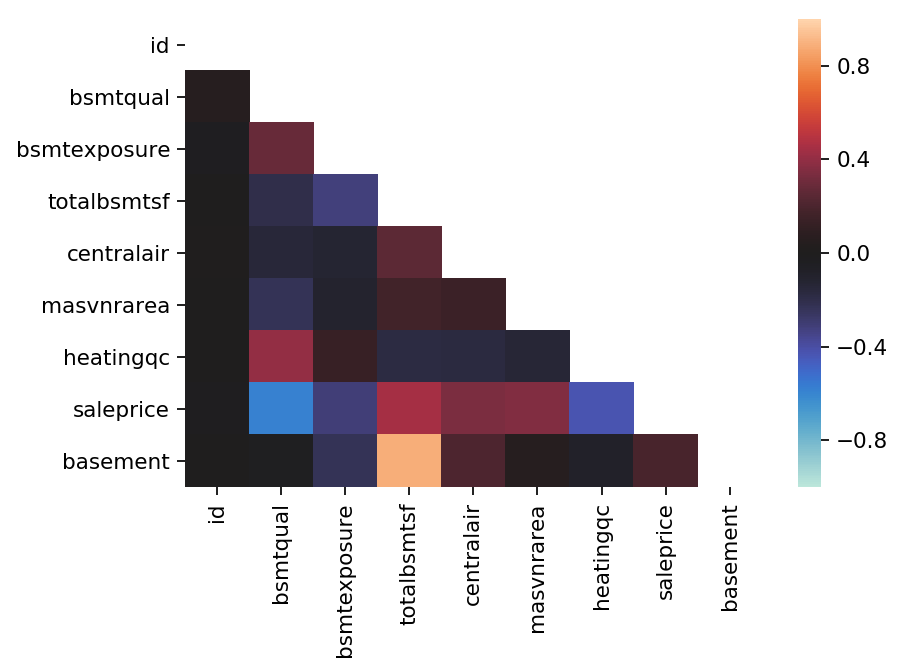

In [43]:
# creating a new feature by copying total basementsf and assigning all values greater than 0 to 1
base_df['basement'] = base_df['totalbsmtsf']
base_df.loc[base_df['totalbsmtsf'] != 0, 'basement'] = 1
heat_map(base_df, -1, 1)

In [44]:
base_df.corr()

,id,bsmtqual,bsmtexposure,totalbsmtsf,centralair,masvnrarea,heatingqc,saleprice,basement
id,1.000000,0.047668,-0.024332,-0.006779,0.009821,0.000816,0.002157,-0.019039,0.004431
bsmtqual,0.047668,1.000000,0.284990,-0.196412,-0.141560,-0.232650,0.402888,-0.585001,-0.034736
bsmtexposure,-0.024332,0.284990,1.000000,-0.315729,-0.122788,-0.107968,0.130856,-0.307212,-0.233825
totalbsmtsf,-0.006779,-0.196412,-0.315729,1.000000,0.255767,0.170870,-0.173554,0.448746,0.886127
centralair,0.009821,-0.141560,-0.122788,0.255767,1.000000,0.141002,-0.164256,0.336594,0.204832
masvnrarea,0.000816,-0.232650,-0.107968,0.170870,0.141002,1.000000,-0.136283,0.351776,0.048834
heatingqc,0.002157,0.402888,0.130856,-0.173554,-0.164256,-0.136283,1.000000,-0.426258,-0.082907
saleprice,-0.019039,-0.585001,-0.307212,0.448746,0.336594,0.351776,-0.426258,1.000000,0.193628
basement,0.004431,-0.034736,-0.233825,0.886127,0.204832,0.048834,-0.082907,0.193628,1.000000


It appears that this new feature is not as informative as I hoped, but that also means that total basementsf is more informative than I thought.

So we'll keep the features discussed earlier:

* bsmtqual
    - Evaluates the height of the basement
        - the taller the better from NA or Poor 70< inches to excellent 100inches>
* bsmtexposure
    - Refers to walkout or garden level walls
* totalbsmtsf
    - Total square feet of the basement area
* centralair
    - Central air conditioning (binary)
* masvnrarea
    - Masonry veneer area in square feet
* heatingqc
    - Heating quality and condition

In [45]:
# merging dataframes on id
house_neo = pd.merge(house_neo, base_df.loc[:, ['id', 'bsmtqual', 'bsmtexposure', 'totalbsmtsf', 'centralair',
                                                'masvnrarea', 'heatingqc', 'saleprice']],
                     left_on='id', right_on='id', how='outer', copy=False)

#### Bed Variables

In [46]:
bed_df = house_t.loc[:, map(lambda x:x.lower(), ['id', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
                                                 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                                                 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu',
                                                 'SaleType', 'SaleCondition', 'saleprice'])]
# there isn't a total bath and total square ft variables so lets create them here
    # the total sf wasn't informative when created but total baths was 
bed_df = cat_converter(bed_df)
bed_df['total_baths'] = bed_df['bsmthalfbath'] + bed_df['bsmtfullbath'] + bed_df['halfbath'] + bed_df['fullbath']
bed_df.corr()

,id,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,kitchenqual,totrmsabvgrd,fireplaces,fireplacequ,saletype,salecondition,saleprice,total_baths
id,1.000000,0.009256,0.011725,-0.035368,0.004646,0.002289,-0.020155,0.005587,0.006784,-0.004432,-0.014002,-0.019772,0.003765,0.019773,-0.005806,-0.019039,0.003105
1stflrsf,0.009256,1.000000,-0.336056,-0.037344,0.548272,0.245607,0.010872,0.371878,-0.135998,-0.328822,-0.002832,0.406202,-0.072121,-0.106118,0.077297,0.612054,0.288871
2ndflrsf,0.011725,-0.336056,1.000000,0.048890,0.575465,-0.209807,-0.025691,0.334480,0.596570,-0.072585,0.085935,0.140166,0.109272,0.057674,0.023458,0.197229,0.400231
lowqualfinsf,-0.035368,-0.037344,0.048890,1.000000,0.097698,-0.055917,-0.008677,-0.000184,-0.024789,0.007195,-0.080713,-0.033995,-0.022259,0.022465,-0.068721,-0.052107,-0.047314
grlivarea,0.004646,0.548272,0.575465,0.097698,1.000000,0.022409,-0.018477,0.653100,0.430610,-0.364488,0.082093,0.470036,0.030735,-0.047461,0.094935,0.730384,0.632493
bsmtfullbath,0.002289,0.245607,-0.209807,-0.055917,0.022409,1.000000,-0.147871,-0.064512,-0.030905,-0.120873,-0.048748,0.137928,0.020993,0.029290,0.011386,0.236720,0.468786
bsmthalfbath,-0.020155,0.010872,-0.025691,-0.008677,-0.018477,-0.147871,1.000000,-0.054536,-0.012340,0.032724,-0.010945,0.028976,0.004022,0.001677,-0.059264,-0.007884,0.136315
fullbath,0.005587,0.371878,0.334480,-0.000184,0.653100,-0.064512,-0.054536,1.000000,0.136381,-0.337604,0.061034,0.243671,0.067848,-0.035458,0.143864,0.594718,0.621043
halfbath,0.006784,-0.135998,0.596570,-0.024789,0.430610,-0.030905,-0.012340,0.136381,1.000000,-0.137756,0.125385,0.203649,0.103887,0.031810,0.072135,0.311865,0.605905
kitchenqual,-0.004432,-0.328822,-0.072585,0.007195,-0.364488,-0.120873,0.032724,-0.337604,-0.137756,1.000000,0.064053,-0.228035,0.206147,0.038590,-0.134391,-0.547997,-0.336181


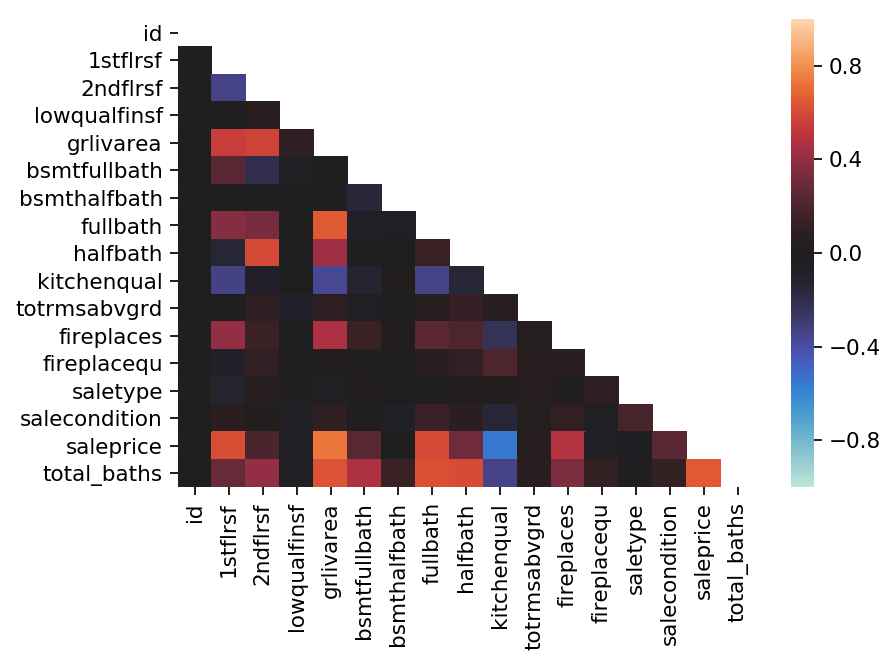

In [47]:
heat_map(bed_df, -1, 1)

In [48]:
# merging dataframes on id
house_chi = pd.merge(house_chi, bed_df, left_on='id', right_on='id', how='outer', copy=False)

Seems like the most interesting variables are:

* 1stflrsf
    - 1st floor square ft
* grlivarea
    - Above grade (ground) living area square feet 4
* fullbath
    - Full bathrooms above grade
* halfbath
    - Half baths above grade
* total_baths
    - sum of baths full = 1 and half = .5
* kitchenqual
    - Kitchen quality
* fireplaces
    - Number of fireplaces

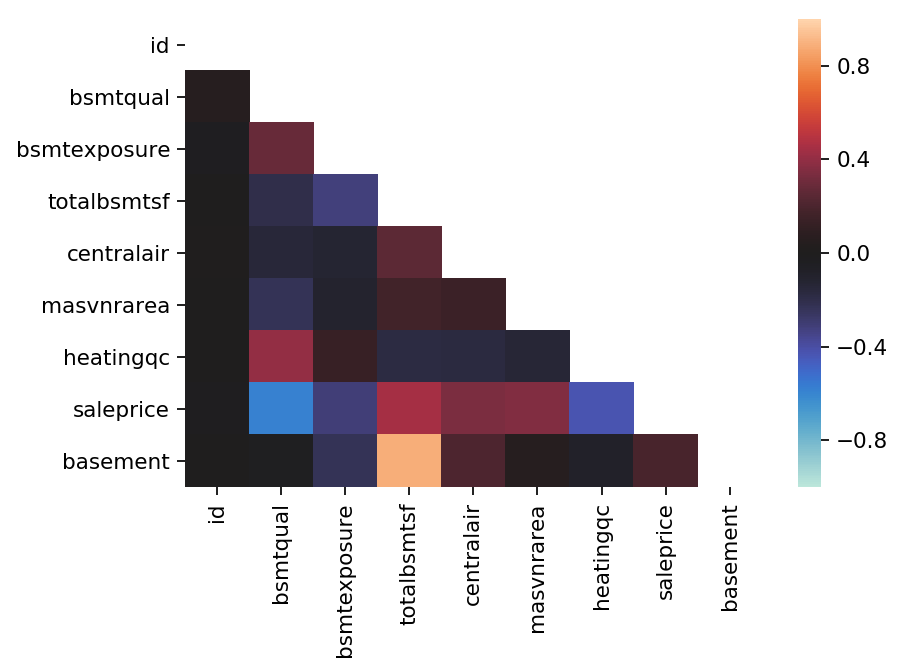

In [49]:
bed_df = bed_df.loc[:, ['id', '1stflrsf', 'grlivarea',
                         'fullbath', 'halfbath', 'total_baths', 'kitchenqual', 
                         'fireplaces', 'saleprice']]
heat_map(base_df, -1, 1)

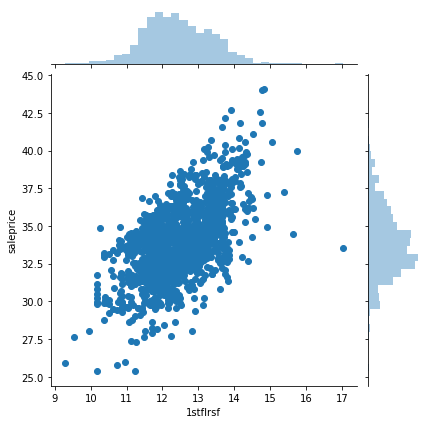

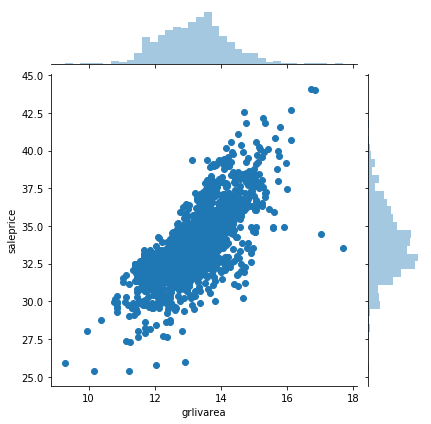

In [50]:
sns.jointplot(x="1stflrsf", y="saleprice", data=bed_df)
sns.jointplot(x="grlivarea", y="saleprice", data=bed_df)

Clipping a few more observations here

In [51]:
bed_df.drop(bed_df[bed_df['1stflrsf'] >= 16].index, inplace = True, axis=0)
bed_df.drop(bed_df[bed_df['grlivarea'] >= 17].index, inplace = True, axis=0)

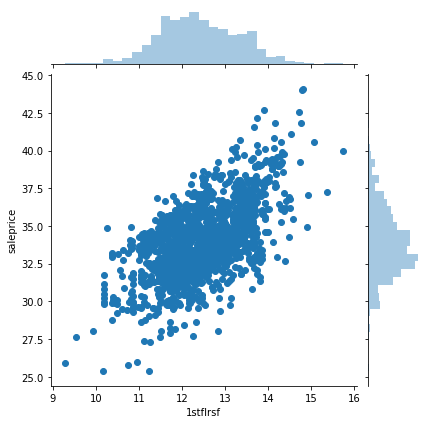

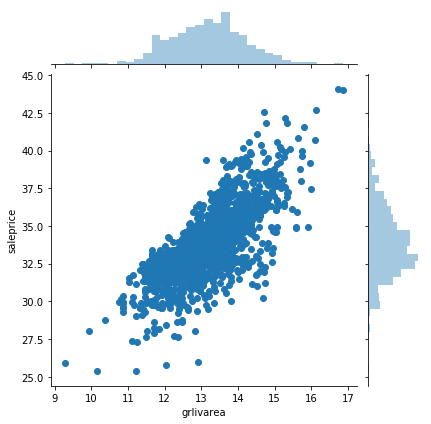

In [52]:
sns.jointplot(x="1stflrsf", y="saleprice", data=bed_df)
sns.jointplot(x="grlivarea", y="saleprice", data=bed_df)

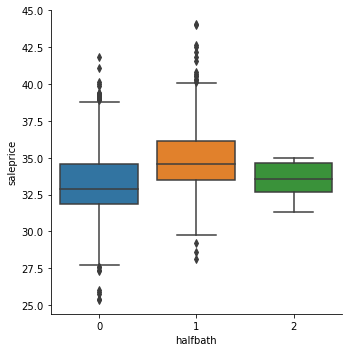

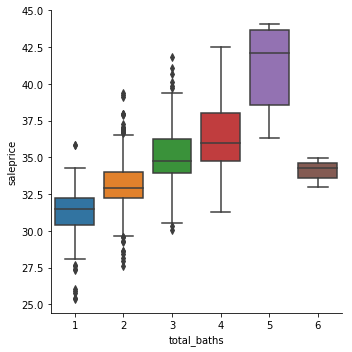

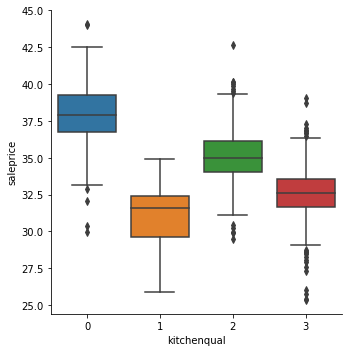

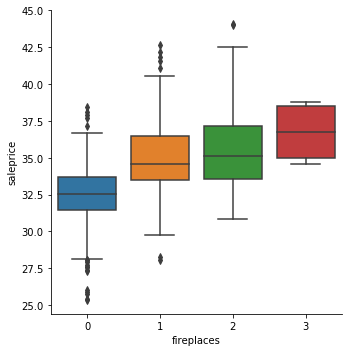

In [53]:
sns.catplot(x="halfbath", y="saleprice", kind="box", data=bed_df, whis=1.5)
sns.catplot(x="total_baths", y="saleprice", kind="box", data=bed_df, whis=1.5)
sns.catplot(x="kitchenqual", y="saleprice", kind="box", data=bed_df, whis=1.5)
sns.catplot(x="fireplaces", y="saleprice", kind="box", data=bed_df, whis=1.5)

,id,1stflrsf,grlivarea,fullbath,halfbath,total_baths,kitchenqual,fireplaces,saleprice
id,1.000000,0.005855,0.001772,0.005750,0.006071,0.001473,-0.002788,-0.023122,-0.018855
1stflrsf,0.005855,1.000000,0.536776,0.368592,-0.145256,0.277594,-0.318130,0.399058,0.620074
grlivarea,0.001772,0.536776,1.000000,0.653375,0.429226,0.627442,-0.354523,0.464832,0.739222
fullbath,0.005750,0.368592,0.653375,1.000000,0.134001,0.619429,-0.333708,0.242375,0.595913
halfbath,0.006071,-0.145256,0.429226,0.134001,1.000000,0.605066,-0.133878,0.201205,0.312115
total_baths,0.001473,0.277594,0.627442,0.619429,0.605066,1.000000,-0.328953,0.336759,0.659536
kitchenqual,-0.002788,-0.318130,-0.354523,-0.333708,-0.133878,-0.328953,1.000000,-0.221993,-0.550836
fireplaces,-0.023122,0.399058,0.464832,0.242375,0.201205,0.336759,-0.221993,1.000000,0.492723
saleprice,-0.018855,0.620074,0.739222,0.595913,0.312115,0.659536,-0.550836,0.492723,1.000000


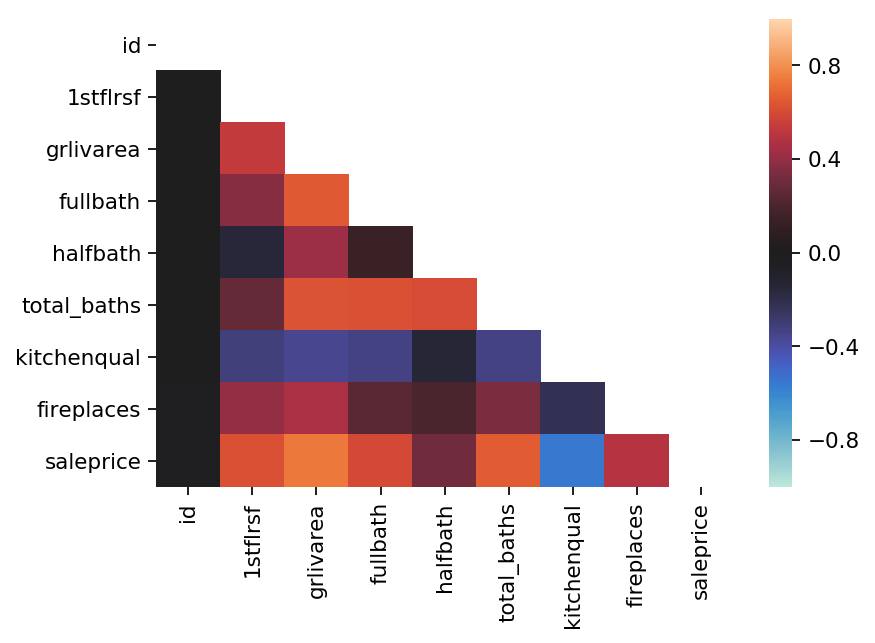

In [54]:
heat_map(bed_df, -1, 1)
bed_df.corr()

In [55]:
house_neo = pd.merge(house_neo, bed_df, left_on='id', right_on='id', how='outer', copy=False)

#### Time Series Variables

In [56]:
time_df = house_t.loc[:, map(lambda x:x.lower(), ['id', 'YrSold', 'MoSold', 'GarageYrBlt',
                                                  'YearRemodAdd', 'YearBuilt',  'saleprice'])]

In [57]:
# merging dataframes on id
house_chi = pd.merge(house_chi, time_df, left_on='id', right_on='id', how='outer', copy=False)

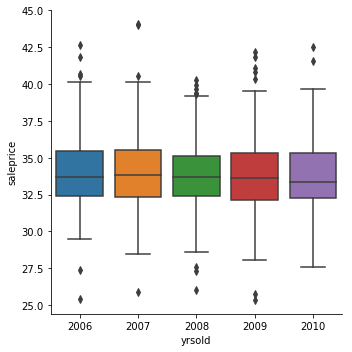

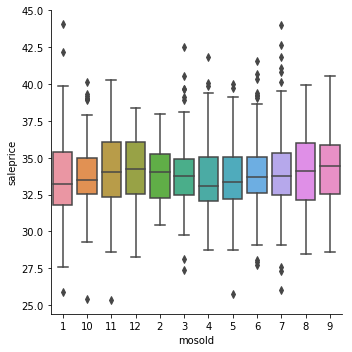

In [58]:
sns.catplot(x="yrsold", y="saleprice", kind="box", data=time_df, whis=1.5)
sns.catplot(x="mosold", y="saleprice", kind="box", data=time_df, whis=1.5)

Month sold and year sold looks as I would expect it too.

Year sold would probably be more helpful if we have more years. (2006 - 2010 is not enough if we had some data back to 1995 and up until 2015, this feature would be more informative because I have a feeling the trend that could be uncovered with this feature needs more than 5 years to reflect the change in salesprice in regard to the year. The undertone here is US economic performance and buyer market impression.

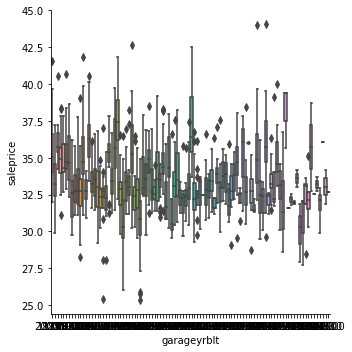

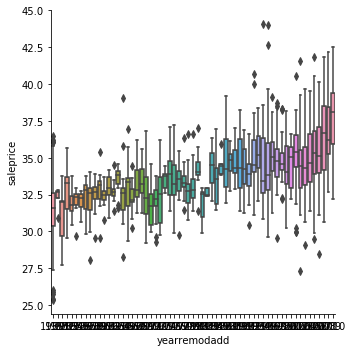

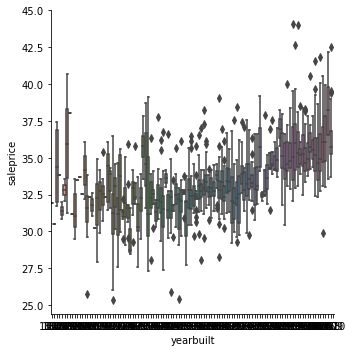

In [59]:
sns.catplot(x='garageyrblt', y="saleprice", kind="box", data=time_df, whis=1.5)
sns.catplot(x="yearremodadd", y="saleprice", kind="box", data=time_df, whis=1.5)
sns.catplot(x="yearbuilt", y="saleprice", kind="box", data=time_df, whis=1.5)

In [60]:
# merging dataframes on id
house_neo = pd.merge(house_neo, time_df.loc[:, ['id', 'garageyrblt', 'yearremodadd', 'yearbuilt', 'saleprice']],
                     left_on='id', right_on='id', how='outer', copy=False)

In [61]:
# deleting extra variables created during the merging process
house_neo = house_neo.drop(['saleprice_x', 'saleprice_y'], axis=1)
house_neo = house_neo.dropna()

In [62]:
# deleting extra variables created during the merging process
house_chi = house_chi.drop(['saleprice_x', 'saleprice_y'], axis=1)
house_chi = house_chi.dropna()

In [63]:
house_chi = cat_converter(house_chi)
house_neo = cat_converter(house_neo)

In [64]:
house_neo.to_csv(r'C:\Users\latee\Documents\GitHub\Supervised Capstone\Iowa_Homes.csv')

In [65]:
house_chi.to_csv(r'C:\Users\latee\Documents\GitHub\Supervised Capstone\Iowa_Homes1.csv')

## Modeling
<i>Models Considered</i>
   * Linear Regression w Robust Scalars (OLS, Lasso, Ridge, ElasticNet Regularization)
       * These models had a much higher root mean squared error than the other models used so they will not be included in this notebook
   * Gradient boosting 
            * Gradient boosting models - models the data over and over using weak learners, each time adjusting the model based on what was learned from the previous one
       * sklearn's GradientBoostingRegressor performed well and has great explanatory and predictive power, but the major drawback is its computational needs
   * eXtreme Gradient Boosting
            * XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. It has recently become popular for its efficiency and use by the Kaggle community
        * XGBoost performed well and as mentioned was more efficient computationally than sklearn Gradient Boosting Regressor. One drawback in comparison to the other model used is its hyperparameter tuning complexity

In [66]:
# Importing libraries needed for modeling
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import  decomposition
from sklearn.feature_selection import SelectKBest, f_regression
import time

### Gradient Boosting Regressor

In [67]:
PATH = r'C:\Users\latee\Documents\GitHub\Supervised Capstone\Iowa_Homes.csv'
house_t = pd.read_csv(PATH)
# selecting data and target
X = house_t.loc[:, ['foundation', 'exterqual', 'lot_size', 'overallqual',
                      'garagetype', 'garagefinish', 'garagecond', 'garagearea',
                      'bsmtqual', 'bsmtexposure', 'totalbsmtsf', 'centralair',
                      'masvnrarea', 'heatingqc', 'grlivarea', 'halfbath', 'fullbath',
                      'total_baths', 'kitchenqual','fireplaces', 'garageyrblt', 'yearremodadd',
                      'yearbuilt']]
y = house_t.saleprice.values.ravel()
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=360)

In [68]:
gbr = GradientBoostingRegressor(loss = "huber",
                                learning_rate = .045,
                                n_estimators = 315,
                                subsample = .675,
                                min_samples_split = 4,
                                min_impurity_decrease = .617,
                                min_samples_leaf = 4,
                                max_features = 10,
                                max_depth = 4,
                                alpha = .961)

In [69]:
# timer script
start_time = time.time()
# Fit the grid search
gbr.fit(X_train, y_train)
# timer script
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.5810260772705078 seconds ---


In [70]:
# we are making predictions here
y_preds_train = gbr.predict(X_train)
y_preds_test = gbr.predict(X_test)
print("R-squared of the model in training set is: {}".format(gbr.score(X_train, y_train)))
print("R-squared of the model in test set is: {}".format(gbr.score(X_test, y_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(np.log10(inv_boxcox1p(y_test, lam)),
                                                                     np.log10(inv_boxcox1p(y_preds_test, lam)))))

R-squared of the model in training set is: 0.9572686840524686
R-squared of the model in test set is: 0.8801486584503325
Root mean squared error of the prediction is: 0.05917714719934288


In [71]:
scores = cross_val_score(gbr, X_train, y_train, cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.89 (+/- 0.02)


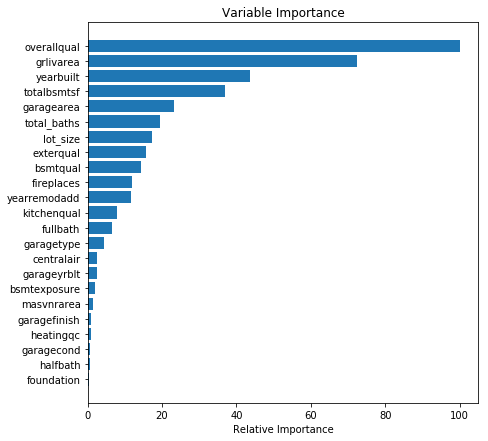

In [72]:
feature_importance = gbr.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(7, 7))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### eXtreme Gradient Boosting

In [73]:
# selecting data and target
X = house_t.loc[:, ['foundation', 'exterqual', 'lot_size', 'overallqual',
                      'garagetype', 'garagefinish', 'garagecond', 'garagearea',
                      'bsmtqual', 'bsmtexposure', 'totalbsmtsf', 'centralair',
                      'masvnrarea', 'heatingqc', 'grlivarea', 'halfbath', 'fullbath',
                      'total_baths', 'kitchenqual','fireplaces', 'garageyrblt', 'yearremodadd',
                      'yearbuilt']]
y = house_t.loc[:, ['saleprice']].values.ravel()
# train terst split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=360)

In [74]:
XGBR = xgb.XGBRegressor(objective ='reg:squarederror',
                        booster = ('gbtree'),
                        learning_rate = .132,
                        max_depth = 3,
                        n_estimators = 100,
                        min_child_weight = 6,
                        max_delta_step = 8,
                        subsample = 1,
                        colsample_bytree = .6,
                        colsample_bylevel = .75,
                        colsample_bynode = .9,
                        reg_alpha = .2,
                        reg_lambda = .3,
                        gamma = 0,
                        scale_pos_weight = 1,
                        base_score = .61)

In [75]:
# timer script
start_time = time.time()
# Fit the grid search
XGBR.fit(X_train, y_train)
# timer script
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.09179878234863281 seconds ---


Note this model took way less time than the other model. Right now both are fast enough to be useful, but as the data scales or the environment changes the need to re-tune hyperparameters will cause some problems for the sklearn gradient boosting regressor. 

In [76]:
# we are making predictions here
y_preds_train = XGBR.predict(X_train)
y_preds_test = XGBR.predict(X_test)
print("R-squared of the model in training set is: {}".format(XGBR.score(X_train, y_train)))
print("R-squared of the model in test set is: {}".format(XGBR.score(X_test, y_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(np.log10(inv_boxcox1p(y_test, lam)),
                                                                     np.log10(inv_boxcox1p(y_preds_test, lam)))))

R-squared of the model in training set is: 0.9374315993392559
R-squared of the model in test set is: 0.8714738374836073
Root mean squared error of the prediction is: 0.06127663178337787


In [77]:
scores = cross_val_score(XGBR, X_train, y_train, cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.89 (+/- 0.02)


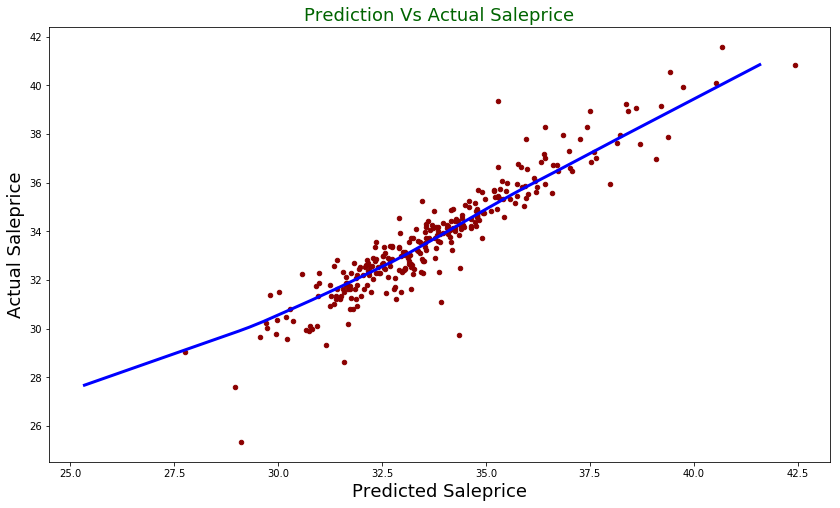

In [78]:
test = pd.DataFrame({"prediction": y_preds_test, "observed": y_test.flatten()})
lowess = sm.nonparametric.lowess
z = lowess(y_preds_test.flatten(), y_test.flatten())
test.plot(figsize = [14,8],
          x ="prediction", y = "observed", kind = "scatter", color = 'darkred')
plt.title("Prediction Vs Actual Saleprice", fontsize = 18, color = "darkgreen")
plt.xlabel("Predicted Saleprice", fontsize = 18) 
plt.ylabel("Actual Saleprice", fontsize = 18)
plt.plot(z[:,0], z[:,1], color = "blue", lw= 3)
plt.show()

### Prediction

In summary, the below cell uploads the testset data that does not come with a saleprice, performs the same transformations, creates the same features, and uses the XGBR model to predict saleprice. Once the saleprice is predicted, it is then inversely transformed, pushed to a data frame with the corresponding IDs, and saved as a CSV to be delivered to Kaggle.

In [79]:
PATH = r'C:\Users\latee\Documents\GitHub\Supervised Capstone\house-prices-advanced-regression-techniques\test.csv'
test_df = pd.read_csv(PATH)
# lowering columns names 
test_df.columns = map(str.lower, test_df.columns)
test_id = test_df['id']
# recreating custom feature used for modeling 
test_df['total_baths'] = test_df['bsmthalfbath'] + test_df['bsmtfullbath'] + test_df['halfbath'] + test_df['fullbath']
# filling in missing data according to notes 
for col in ('poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ', 'garagecond',
            'garagetype', 'garageyrblt', 'garagefinish', 'garagequal', 'bsmtexposure',
            'bsmtfintype2', 'bsmtfintype1', 'bsmtcond', 'bsmtqual', 'masvnrarea', 'masvnrtype'):
    test_df[col] = test_df[col].fillna('None')
# get a list of neightborhoods
neighborhoods = test_df['neighborhood'].unique()
# fill na values with average based on neighborhood
for col in ['lotfrontage', 'total_baths', 'garagearea', 'totalbsmtsf']:
    for neighborhood in neighborhoods:
        test_df.loc[test_df["neighborhood"] == neighborhood, col] = test_df.loc[test_df["neighborhood"] == neighborhood, col].fillna(
            test_df[test_df["neighborhood"] == neighborhood][col].mean())
# fill na values with average based on the neighborhood count for that value
for col in ['electrical', 'kitchenqual']:
    for neighborhood in neighborhoods:
        test_df.loc[test_df["neighborhood"] == neighborhood, col] = test_df.loc[test_df["neighborhood"] == neighborhood, col].fillna(
            test_df[test_df["neighborhood"] == neighborhood][col].value_counts().index[0])
for col in ('foundation', 'exterqual', 'overallqual', 'garagetype', 'garagefinish', 'garagecond',
            'bsmtqual', 'bsmtexposure', 'centralair', 'heatingqc', 'halfbath', 'fullbath', 'kitchenqual',
            'fireplaces', 'garageyrblt', 'yearremodadd', 'yearbuilt'):
    test_df[col] = test_df[col].astype(str)
# Applying the same transformation to test features that I did with training data features
numeric_columns = test_df.select_dtypes(['int64', 'float64']).columns
skewed_feats = test_df[numeric_columns].apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    test_df[feat] = boxcox1p(test_df[feat], lam)
# recreating custom feature used for modeling 
test_df['lot_size'] = test_df['lotarea'] + test_df['lotfrontage']
# testing features
test_data = test_df.loc[:, X.columns]
test_data = cat_converter(test_data)
submission = pd.DataFrame({'id' : test_id, 'saleprice' : inv_boxcox1p(XGBR.predict(test_data), lam)})
submission.to_csv(r'C:\Users\latee\Documents\GitHub\Supervised Capstone\kaggle_Iowa.csv', index=False)

Below is the submission I made to Kaggle.

In [80]:
submission

,id,saleprice
0,1461,114717.960938
1,1462,139424.859375
2,1463,171077.421875
3,1464,170127.156250
4,1465,160456.015625
5,1466,167862.546875
6,1467,161753.437500
7,1468,153074.203125
8,1469,189232.203125
9,1470,103666.414062


### Results from Public Leaderboard

This leaderboard is calculated with approximately 50% of the test data.

The final results will be based on the other 50%, so the final standings may be different.

Placement: 3716

Score: 0.17988